In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Gaussian Processes (Noisy setting)
## (Regression - Gaussian Likelihood)
In a noisy setting, actual response is a sum of function output and noise ($y_n = f(\mathbf{x}_n) + \epsilon_n$). Consider a regression model where we assume that each response is modelled by a Gaussian Likelihood $p(y_n|f_n,\beta^{-1}) = \mathcal{N}(f_n,\beta^{-1})$. We can write the total likelihood as:
$$p(\mathbf{y}|\mathbf{f},\beta^{-1}\mathbf{I}) = \mathcal{N}(\mathbf{f},\beta^{-1}\mathbf{I})$$

Assuming a zero mean Gaussian Prior as:
$$p(\mathbf{f}) = \mathcal{N}(\mathbf{0},\mathbf{K})$$
Snce both likelihood and prior are gaussian here, the marginal likelihood of $y$ is also gaussian:
$$p(\mathbf{y}) = \mathcal{N}(\mathbf{0},\mathbf{K} + \beta^{-1} \mathbf{I}_N ) = \mathcal{N}(\mathbf{0}, \mathbf{C}_N )$$
where 
$\mathbf{K}$ = \begin{bmatrix} 
    \kappa(x_1, x_1) & \kappa(x_1, x_2) & \dots & \kappa(x_1, x_N)\\
    \kappa(x_2, x_1) & \kappa(x_2, x_2) & \dots & \kappa(x_2, x_N)\\
    \vdots & \vdots & \ddots &\\
    \kappa(x_N, x_1) & \kappa(x_N, x_2) & \dots & \kappa(x_N, x_N)
    \end{bmatrix}
    
    
The Joint distribution of the training $\mathbf{y}$ and the test response $y_*$ is also gaussian:

$$p\left(\begin{bmatrix} 
    \mathbf{y} \\ y_* \end{bmatrix}\right) = \mathcal{N}\left(\begin{bmatrix} 
    \mathbf{0} \\ 0 \end{bmatrix},\begin{bmatrix} 
    \mathbf{C}_N & \mathbf{k}_* \\ \mathbf{k}_*^T & \kappa(x_*, x_*) + \beta^{-1}\end{bmatrix}\right)$$
    
 where $\mathbf{k}_* = [\kappa(x_1, x_*), \kappa(x_2, x_*), \dots, \kappa(x_N, x_*)]^T$.
 
 Using the gaussian property and the above results we can write,
 
 $$p(y_*|\mathbf{y}) = \mathcal{N}(\mathbf{k}_*^T \mathbf{C}_N^{-1}\mathbf{y} ,\kappa(x_*, x_*) - \mathbf{k}_*^T \mathbf{C}_N^{-1}\mathbf{k}_* + \beta^{-1}) $$
 
 __Implementation:__ The data is generated using a sinusoid function. In the range between "lowrange" and "uprange", a few points are randomly selected, which denotes the data. Using GP, the function value is predicted along with its uncertainity (using the formulas above). These are further plotted where blue curve represents mean prediction and the red are represents corresponding uncertainity. Noise($\beta$) can be tuned to see the effect of changing noise on the plot

# Custom Function

In [20]:
def createData(N,lowrange,uprange, beta):
    '''
    Creating Data points X and corresponding outputs Y using SINUSOID FUNCTION
    Input:
        N: No. of data points to be generated 
        
    Output:
        X: np vector of shape (N,)
        Y: np vector of shape (N,)
    '''
    s = np.random.uniform(lowrange,uprange,N)
    X = np.sort(s, axis=None)
    mu = 0
    sigma = np.sqrt(1/beta)
    noise = np.random.normal(mu, sigma, N)
    Y = np.sin(X) + noise
    return X, Y

def KernelSExp(sig, l, x1, x2):
    '''
    Generate Squared Exponential Kernel for inputs x1 and x2
    Input:
        sig: scalar
        l: scalar
        x1: scalar data point 1
        x2: scalar data point 2
    Output:
        kse: scalar output of square exponential kernel for x1 and x2
    '''
    kse = (sig**2) * np.exp(-((x1-x2)**2)/(2*l*l))
    return kse

def createKernelMatrix(X,KernelValFunc, sig, l):
    '''
    Creating Kernel Matrix for function data points X a using  KernelFunc
    Input:
        X: Data points -  np vector of shape (N,)
        KernelFunc: The function used to compute kernels
        
    Output:
        K: np matrix of shape (N,N)
    '''
    N = len(X)
    K  = np.zeros((N,N))
    for i in range(N):
        for j in range (N):
            K[i,j] = KernelValFunc(sig, l, X[i], X[j])
    return K

def createCMatrix(X,KernelValFunc, sig, l, beta):
    '''
    Creating Kernel Matrix for function data points X a using  KernelFunc
    Input:
        X: Data points -  np vector of shape (N,)
        KernelFunc: The function used to compute kernels
        
    Output:
        K: np matrix of shape (N,N)
    '''
    N = len(X)
    K  = createKernelMatrix(X,KernelValFunc, sig, l)
    eye = np.identity(N, dtype = float)
    C = K + (1/beta) * eye
    return C

def ComputeGP_PPDmeancov(x_new, X, Y, KernelFunc, KernelValFunc, sig, l, beta):
    '''
    Computing PPD mean for GP PPD
    Input:
        x_new = new data point - scalar
        X: Data points -  np vector of shape (N, )  
        Y: Output at Data points -  np vector of shape (N, )
        KernelFunc: The function used to compute kernel matrix
        KernelValFunc: The function used to compute kernel value for particular data pair
    Output:
        GP_PPD_Mean: scalar
        GP_PPD_Cov: scalar
    '''
    N  = len(X)
    C  = createCMatrix(X,KernelValFunc, sig, l, beta)
    kernelval_new = KernelValFunc(sig, l, x_new, x_new)
    k_new = np.zeros(N)
    for i in range(N):
        k_new[i] = KernelValFunc(sig, l, X[i], x_new)
    
    C_inv = np.linalg.inv(C)
    GP_PPD_Mean = k_new@C_inv@Y
    GP_PPD_Cov = kernelval_new - k_new@C_inv@k_new + (1/beta)
    return GP_PPD_Mean, GP_PPD_Cov

# GP in Noisy Setting

In [26]:
lowrange = -5
uprange = 5
N = 5
sig = 2
l = 2
NoSamples = 50
beta = 10
X, Y = createData(N,lowrange,uprange,beta)

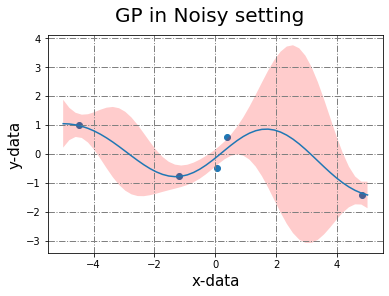

In [27]:
XX = np.linspace(lowrange, uprange, num=NoSamples)
PPD_MeanCov = np.zeros((NoSamples,2))
for i in range(len(XX)):
    PPD_MeanCov[i,0], PPD_MeanCov[i,1]  = ComputeGP_PPDmeancov(XX[i], X, Y, createKernelMatrix, KernelSExp, sig, l,beta)
    

plot1 = plt.figure(1)
plt.scatter(X,Y)
plt.plot(XX,PPD_MeanCov[:,0])
a1 = PPD_MeanCov[:,0] - 2*PPD_MeanCov[:,1]
a2 = PPD_MeanCov[:,0] + 2*PPD_MeanCov[:,1]
plt.fill_between(XX, a1, a2, facecolor='r', alpha=0.2)
plt.xlabel('x-data', fontsize=15)
plt.ylabel('y-data', fontsize=15)
plt.suptitle('GP in Noisy setting', fontsize=20)
plt.grid(True, color = "grey", linewidth = "1", linestyle = "-.")
plt.show()